# Class 10 - Responsible AI: Explainability

## Agenda
1. Transparency and Explainability
    - Model coefficients interpretation
    - Explainability

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,  roc_curve, auc

# Initialize shap
import shap
shap.initjs()

/anaconda/envs/mlcourse_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
data_url = 'https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/MLCatolica24/main/Aula%2010%20-%20%20Responsible%20AI/data/liver_disease_data.csv'
df = pd.read_csv(data_url, index_col = 'id')
df.shape

HTTPError: HTTP Error 404: Not Found

In [3]:
# see first rows
df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
id,,,,,,,,,,,
572,75,1,32.960731,10.911642,0,0,8.930014,0,1,89.950963,1
125,20,1,30.298513,9.417347,0,0,1.484017,0,0,75.777573,1
1553,21,1,33.230869,1.685287,1,1,3.411027,0,0,69.226081,1
459,54,1,35.986523,16.569763,1,1,4.582832,0,0,53.761885,1
216,47,0,19.132353,15.074681,1,2,5.380676,0,0,23.547537,1


## EDA

In [4]:
# Obtain statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,804.0,47.358209,17.565988,20.000000,33.000000,45.000000,63.000000,80.000000
Gender,804.0,0.406716,0.491527,0.000000,0.000000,0.000000,1.000000,1.000000
BMI,804.0,26.506065,7.342491,15.004710,20.097827,25.821237,33.276118,39.992845
AlcoholConsumption,804.0,7.828501,5.394764,0.003731,3.422090,6.641081,11.409950,19.952456
Smoking,804.0,0.201493,0.401365,0.000000,0.000000,0.000000,0.000000,1.000000
GeneticRisk,804.0,0.444030,0.573905,0.000000,0.000000,0.000000,1.000000,2.000000
PhysicalActivity,804.0,5.322936,2.724577,0.001852,3.123983,5.317782,7.636504,9.994964
Diabetes,804.0,0.104478,0.306070,0.000000,0.000000,0.000000,0.000000,1.000000
Hypertension,804.0,0.094527,0.292743,0.000000,0.000000,0.000000,0.000000,1.000000
LiverFunctionTest,804.0,51.545103,22.441134,20.051157,33.101701,45.875110,67.969025,99.859513


In [5]:
# Check the distributions of the classes
df['Diagnosis'].value_counts()

Diagnosis
0    764
1     40
Name: count, dtype: int64

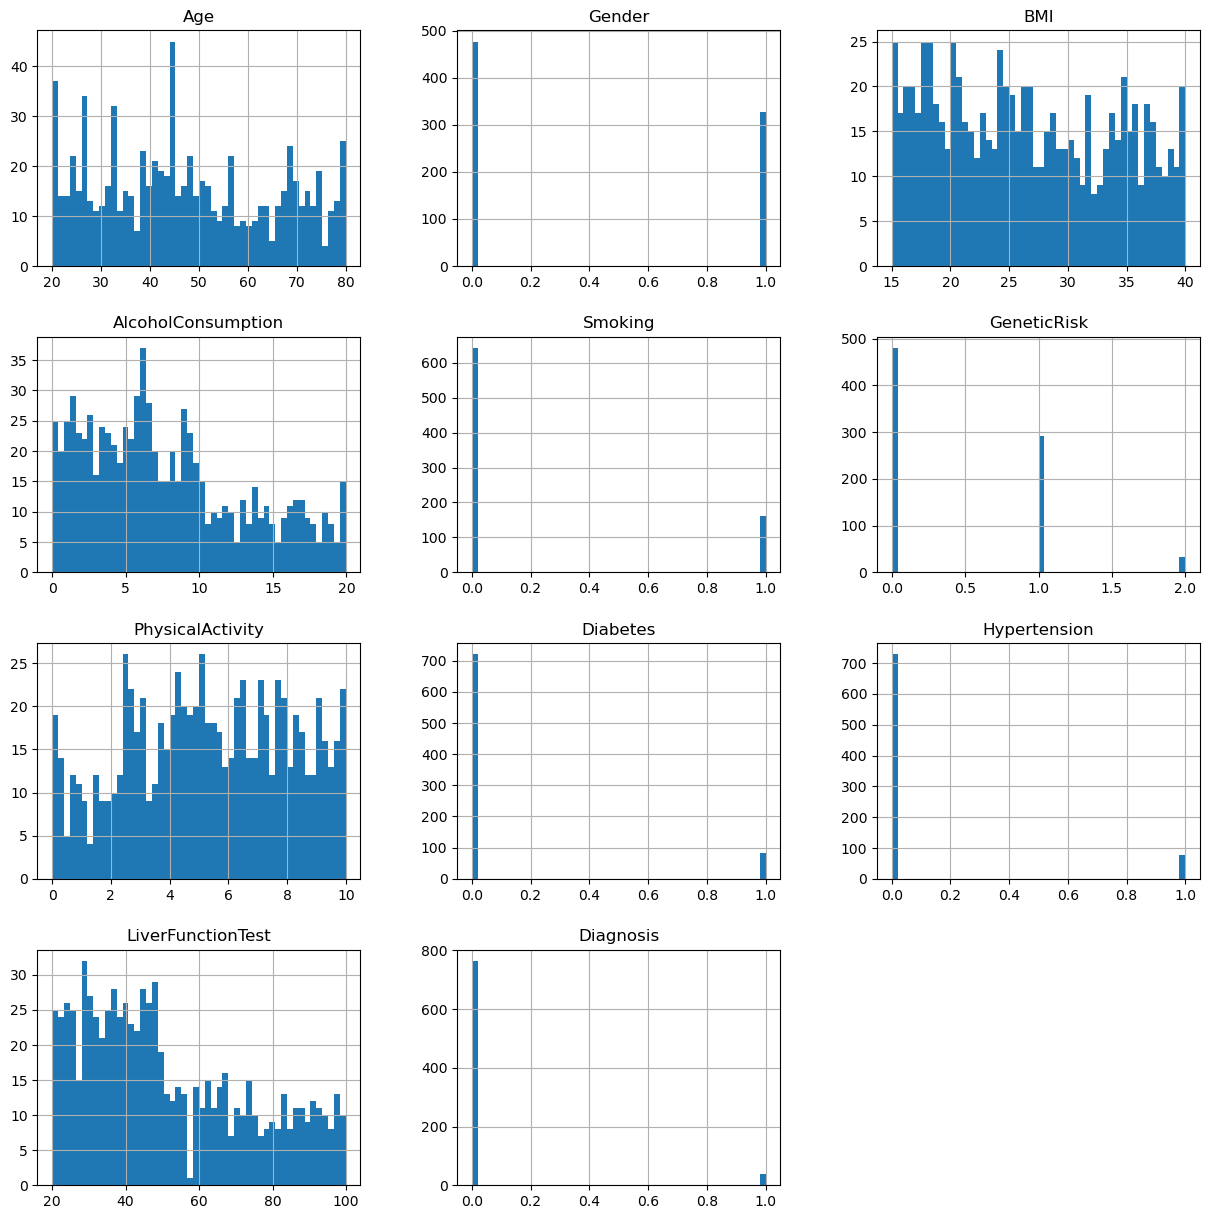

In [6]:
# Plot the histograms
hists = df.hist(bins=50, figsize=(15,15))
plt.show()

## Data Selection and Train/Test split

In [21]:
# DEfine the target column
target_col = 'Diagnosis'

In [22]:
# Select the features to the X and y variables
X = df.drop(columns=[target_col])
y = df[target_col]

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [24]:
# Select continuous and categorical columns
continuous_cols = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest']
categorical_cols = ['Gender', 'Smoking', 'GeneticRisk', 'Diabetes', 'Hypertension']

In [25]:
# Create copy of the X_train and X_test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [26]:
# Scale the continuous variables
scaler = StandardScaler()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [27]:
X_train_scaled.head(3)

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest
id,,,,,,,,,,
1195,0.377127,1,-1.003304,0.890640,0,0,0.391434,0,0,-0.602640
489,-0.644372,1,-0.131750,1.262316,1,1,-0.388309,0,0,0.651635
1518,-0.984871,1,1.401835,-0.327567,0,0,1.667050,0,0,2.239503


## 1. Transparency and Explainability

### 1.1. Logistic Regression

Model Training

In [30]:
# Train a Logistic Regression with class_weight 'balanced'
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Model Evaluation

In [31]:
# Predict the classes for X_test
y_predict = clf.predict(X_test_scaled)

In [32]:
# Check the accuracies
accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.81


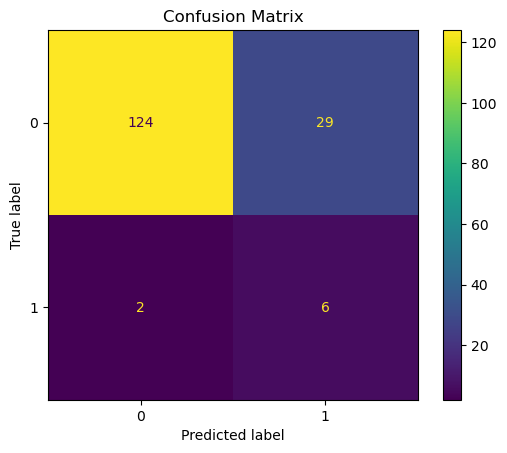

In [33]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Model coefficients interpretation

Odds Ratio (Recap from class 6)

In [34]:
# Extract coefficients and feature names
coefficients = clf.coef_[0]
feature_names = X.columns

In [35]:
coefficients

array([ 0.02412267,  1.13364439,  0.61286046,  1.40725677,  1.79264846,
        0.94603064, -0.59918715,  1.82389581,  2.0054986 ,  1.08053972])

In [36]:
feature_names

Index(['Age', 'Gender', 'BMI', 'AlcoholConsumption', 'Smoking', 'GeneticRisk',
       'PhysicalActivity', 'Diabetes', 'Hypertension', 'LiverFunctionTest'],
      dtype='object')

In [37]:
# COmpute the exponential function
odds_ratio = np.exp(coefficients)

In [38]:
# Sort coefficients and feature names by absolute odds_ration
sorted_indices = np.argsort(np.abs(odds_ratio))[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_odds = odds_ratio[sorted_indices]

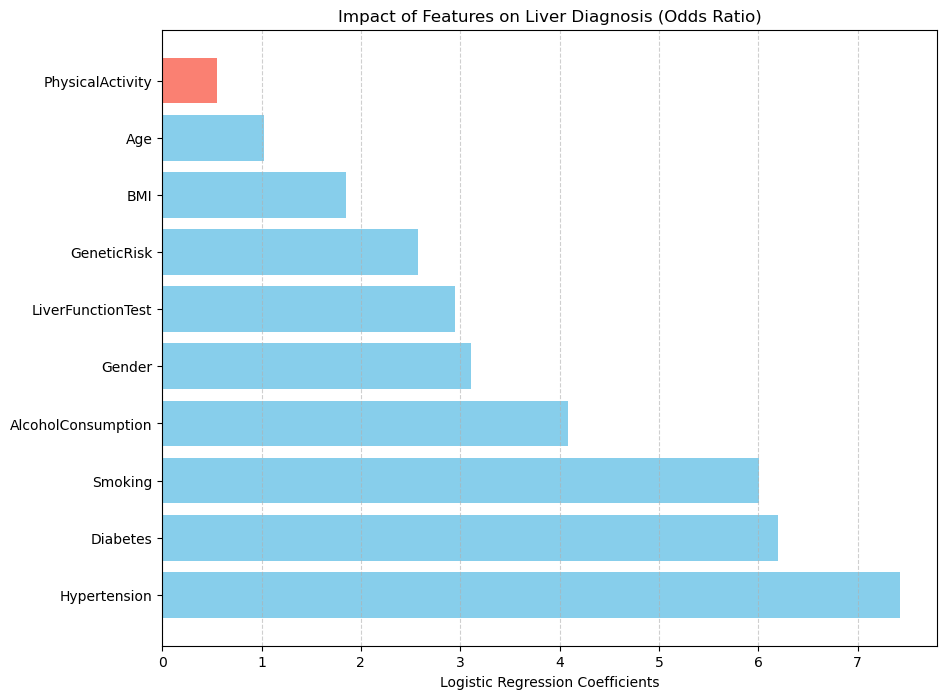

In [39]:
# Plot the odds ratio
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_odds, color=['skyblue' if coef > 1 else 'salmon' for coef in sorted_odds])
plt.xlabel('Logistic Regression Coefficients')
plt.title('Impact of Features on Liver Diagnosis (Odds Ratio)')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

SHAP values 
- They take into consideration not only the model weights but also the values

In [40]:
# Initialize the SHAP explainer
explainer_LR = shap.LinearExplainer(clf, X_train_scaled)

In [41]:
# COmpute the shap values for the X_test dataset
shap_values_LR = explainer_LR.shap_values(X_test_scaled)

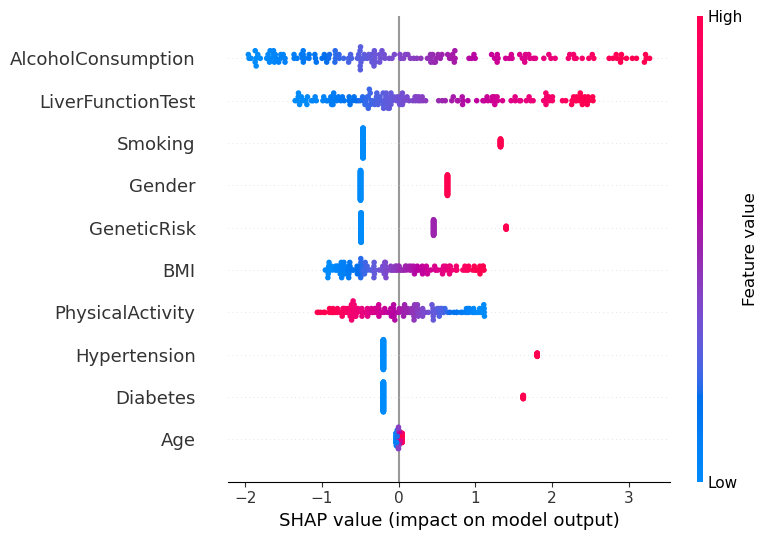

In [42]:
# Plot summary_plot of shap
shap.summary_plot(shap_values_LR, X_test_scaled, feature_names=X.columns)

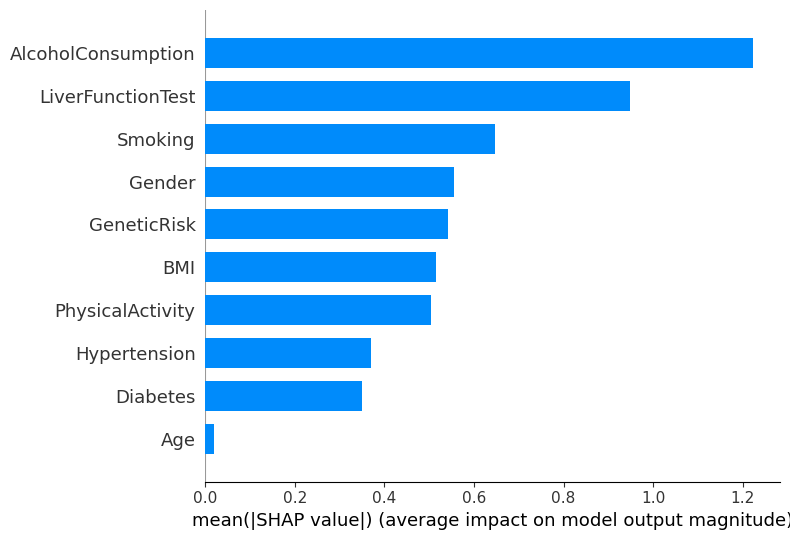

In [43]:
# Plot summary_plot with bars
shap.summary_plot(shap_values_LR, X_test_scaled, feature_names=X.columns, plot_type='bar')

### 1.2. Decision Tree

Model Training

In [45]:
# Train the decision tree model
dt_model = DecisionTreeClassifier(max_depth=5 ,class_weight='balanced',random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Model Evaluation

In [46]:
# Make predictions on train set
y_pred_dt = dt_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_dt)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.88


In [47]:
# Make predictions on test set
y_pred_dt = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.78


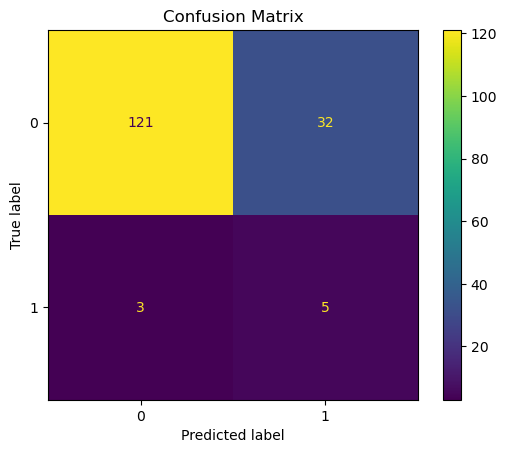

In [48]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

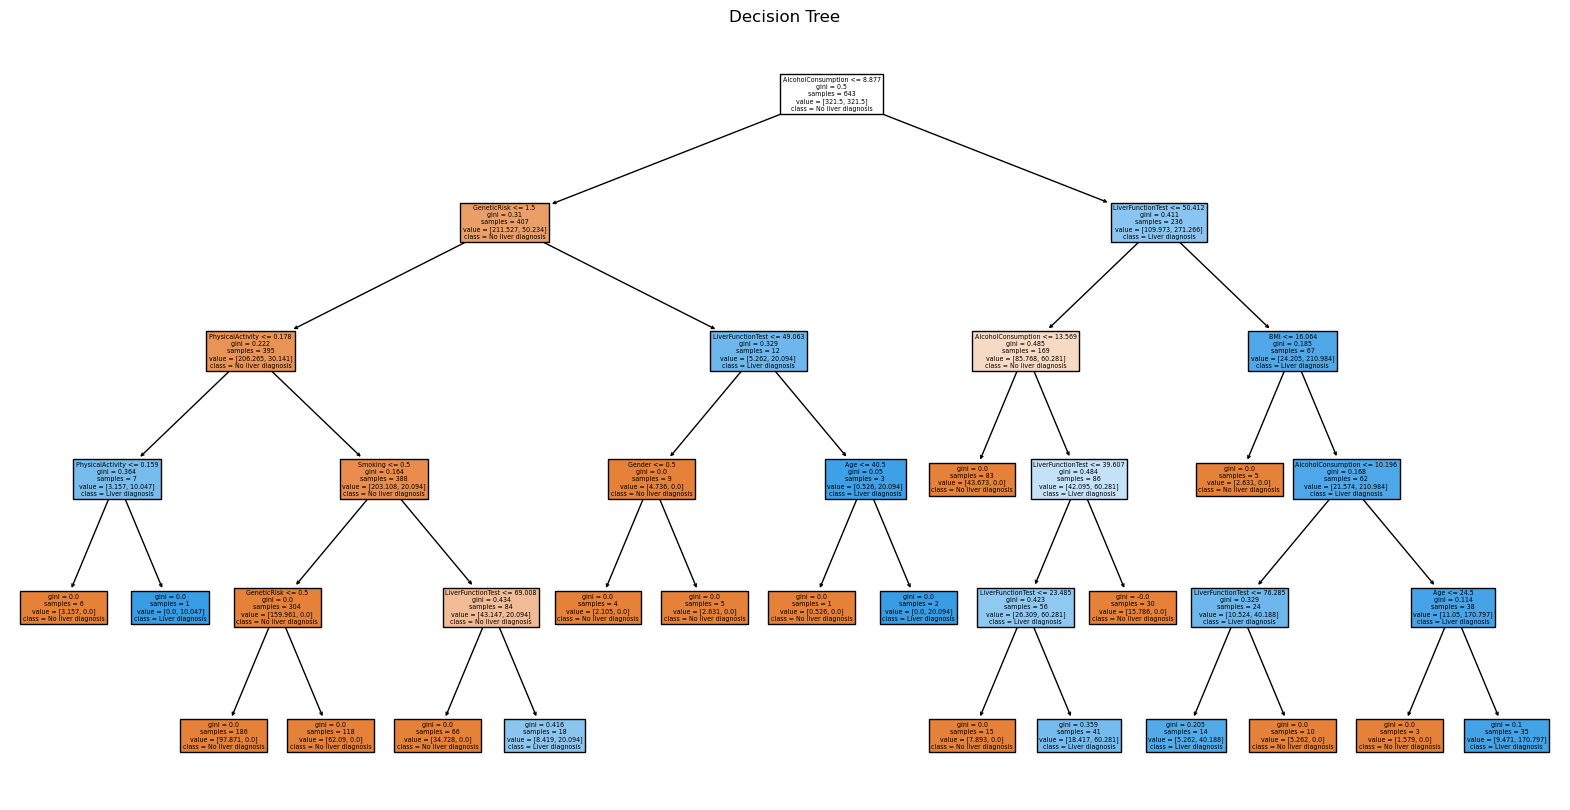

In [49]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['No liver diagnosis', 'Liver diagnosis'], filled=True)
plt.title('Decision Tree')
plt.show()

Feature Importance (Recap from class 7)

In [50]:
# Retrieve feature importances
feature_importances = dt_model.feature_importances_

In [51]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

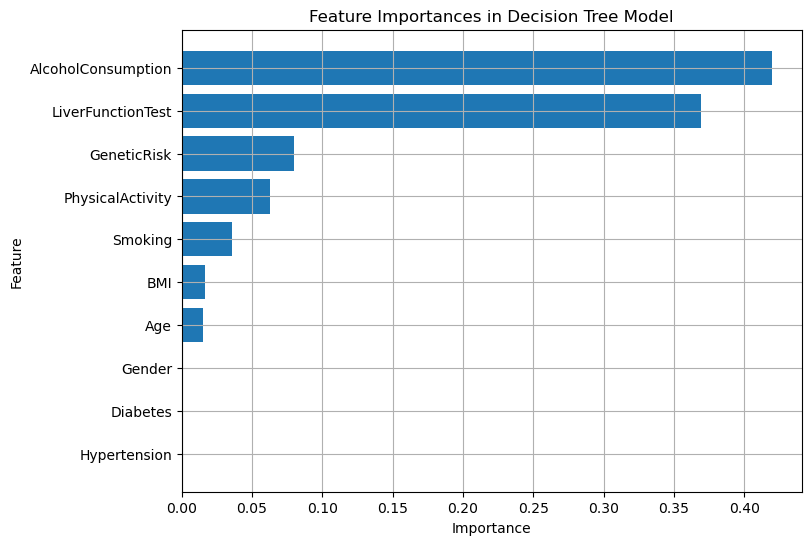

In [33]:
# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(True)
plt.show()

SHAP values

In [53]:
# Initialize SHAP for Tree based models
explainer_dt  = shap.TreeExplainer(dt_model)

In [56]:
# Compute SHAP values for X_test given the Decision Tree model trained
shap_values_dt = explainer_dt(X_test).values[:, :, 1]

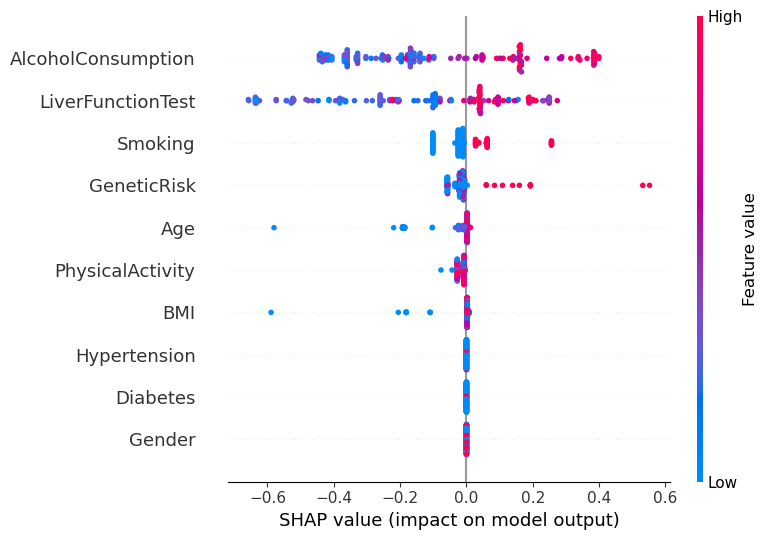

In [55]:
# Plot summary plot
shap.summary_plot(shap_values_dt, X_test)

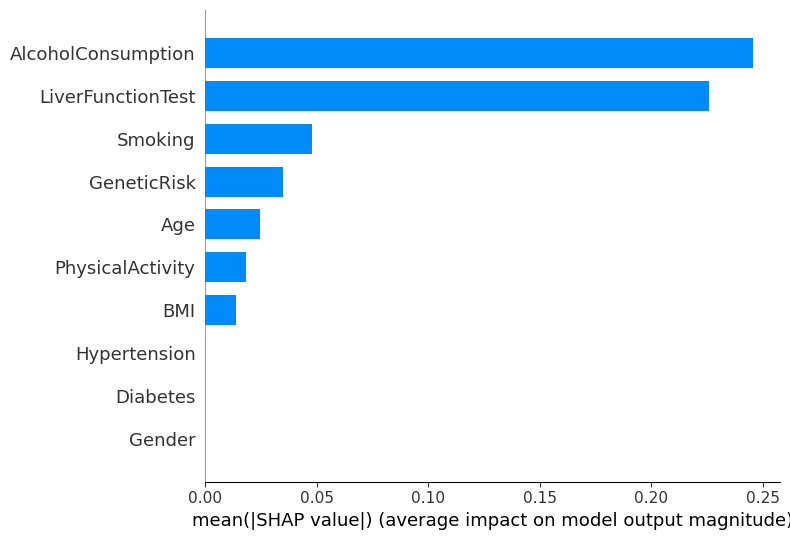

In [57]:
# Plot bar summary_plot
shap.summary_plot(shap_values_dt, X_test, plot_type="bar")

### Random Forest

Model Traning

In [59]:
# Train the Random Forest model --> we are choosing a random attributes just to prevent overfitting
RF_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10, min_samples_split=10,class_weight='balanced',random_state=42)
RF_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=42)

Model Evaluation

In [60]:
# Make predictions on train set
y_pred_RF = RF_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_RF)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.98


In [61]:
# Make predictions on test set
y_pred_RF = RF_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_RF)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.94


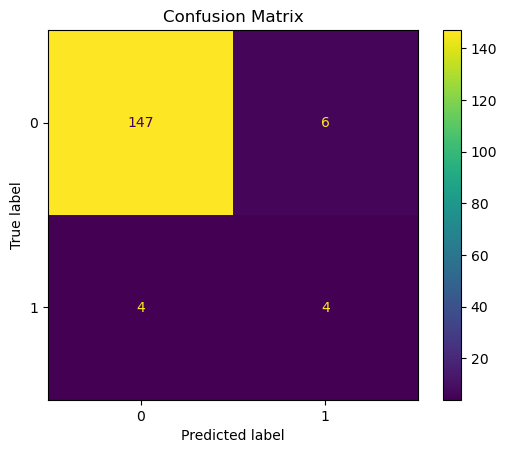

In [62]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=RF_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Feature Importance

- Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree

In [78]:
# Retrieve feature importances
feature_importances = RF_model.feature_importances_

In [79]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

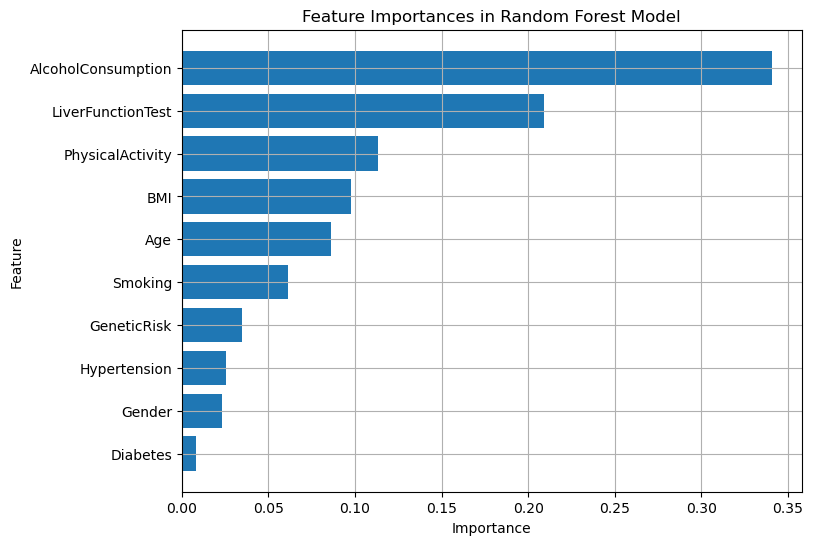

In [80]:
# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(True)
plt.show()

SHAP values

In [82]:
# Initialize 
explainer_rf  = shap.TreeExplainer(RF_model)
explanation_rf = explainer_rf(X_test)

In [83]:
shap_values_rf = explanation_rf.values[:, :, 1]

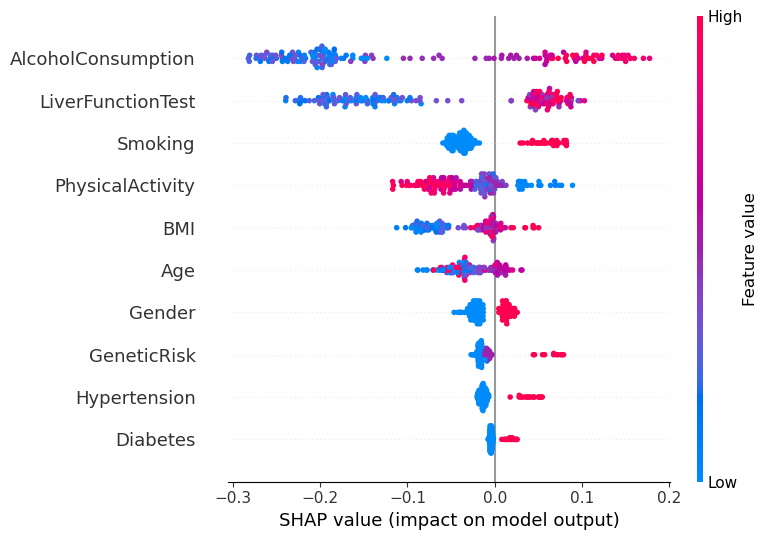

In [84]:
shap.summary_plot(shap_values_rf, X_test)

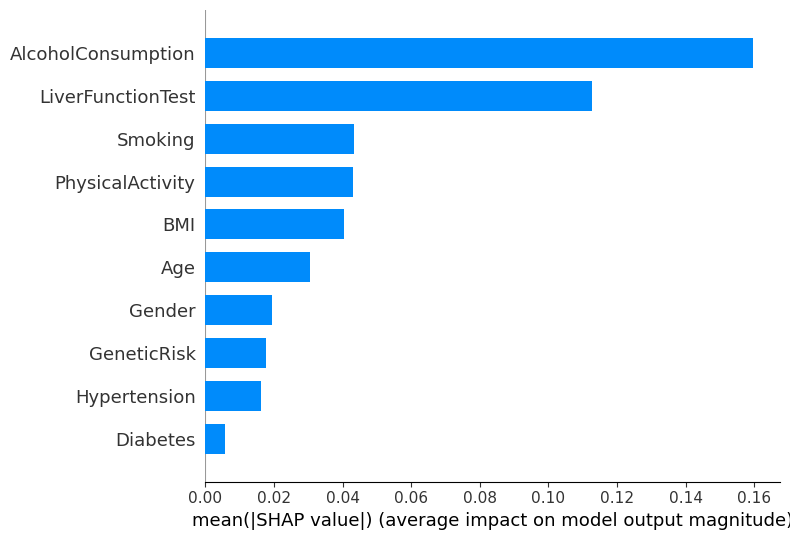

In [85]:
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")